# Imports and modules

In [1]:
import pandas as pd
import time 
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import geopandas as gpd

from datetime import datetime
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, classification_report
from sklearn.model_selection import  train_test_split, cross_validate
from sklearn import svm
from sklearn.feature_selection import r_regression
from sklearn.neighbors import KNeighborsClassifier
from shapely.geometry import Point
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_fscore_support

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Extract from CSV and Preprocessing

## Function to extract data from CSV

In [2]:
def get_data(path, file_names):
    tables=[]
    for file_name in file_names:
        table = pd.read_csv(f'../{path}/{file_name}.csv')
        table['type']=f'{file_name}'
        tables.append(table)
    return pd.concat(tables)

path='data/raw_data'
file_names = ['trawlers', 'drifting_longlines', 'fixed_gear', 'pole_and_line', 'purse_seines', 'trollers', 'unknown']
df = get_data(path, file_names)
df.head(3)

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source,type
0,1.252340e+12,1.325376e+09,0.0,0.0,0.0,153.0,52.458649,4.581200,-1.0,gfw,trawlers
1,1.252340e+12,1.325378e+09,0.0,0.0,0.0,153.0,52.458668,4.581167,-1.0,gfw,trawlers
2,1.252340e+12,1.325379e+09,0.0,0.0,0.0,153.0,52.458633,4.581183,-1.0,gfw,trawlers


In [3]:
# Unique number of ships
df['mmsi'].nunique()

354

## Remove unknown (-1 in is_fishing column)

In [4]:
df = df.loc[df['is_fishing'] > -1]
df['is_fishing'].value_counts()

is_fishing
0.000000    295979
1.000000    247498
0.666667      4806
0.333333      4096
0.750000       752
0.250000       670
0.800000        33
0.166667        12
0.400000         9
Name: count, dtype: int64

## Converting is_fishing to Binary (0 or 1)

In [5]:
df_fishing = df

# round the decimals so that number becomes 0 or 1
df_fishing.loc[:, ('is_fishing')] = round(df_fishing.loc[:, ('is_fishing')])

# check the unique values
df_fishing['is_fishing'].value_counts()

is_fishing
0.0    300766
1.0    253089
Name: count, dtype: int64

# Date Engineering

## Converting timestamp to datetime format

In [6]:
df_fishing['date'] = pd.to_datetime(df_fishing['timestamp'], unit='s')
df_fishing.drop(columns =['timestamp'], inplace=True)

# Convert date to numerical values
df_fishing['month'] = df_fishing['date'].dt.month
df_fishing['day_of_week'] = df_fishing['date'].dt.day_of_week

## Using Angular distance for the days of the week

In [7]:
df_fishing['day_of_week_sin'] = np.sin(df_fishing['day_of_week'] * (2 * np.pi / 7))
df_fishing['day_of_week_cos'] = np.cos(df_fishing['day_of_week'] * (2 * np.pi / 7))

## Encoding dates

In [8]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder(sparse_output =False)

# Fit encoder
ohe.fit(df_fishing[['day_of_week']])

# Transform the current "day_of_week" column
df_fishing[ohe.get_feature_names_out()] = ohe.transform(df_fishing[['day_of_week']])

# Drop the column "day_of_week" which has been encoded
df_fishing.drop(columns = ["day_of_week"], inplace = True)

In [9]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder(sparse_output =False)

# Fit encoder
ohe.fit(df_fishing[['month']])

# Transform the current "month" column
df_fishing[ohe.get_feature_names_out()] = ohe.transform(df_fishing[['month']])

# Drop the column "month" which has been encoded and "day_of_week"
df_fishing.drop(columns = ["month"], inplace = True)
df_fishing.head(2)

,mmsi,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source,type,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
60646,1.252340e+12,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,gfw,trawlers,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60647,1.252340e+12,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,gfw,trawlers,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Removing boats with less than a number of occurences

In [10]:
df_fishing.dropna(inplace=True)
df_fishing.isna().sum()

mmsi                   0
distance_from_shore    0
distance_from_port     0
speed                  0
course                 0
lat                    0
lon                    0
is_fishing             0
source                 0
type                   0
date                   0
day_of_week_sin        0
day_of_week_cos        0
day_of_week_0          0
day_of_week_1          0
day_of_week_2          0
day_of_week_3          0
day_of_week_4          0
day_of_week_5          0
day_of_week_6          0
month_1                0
month_2                0
month_3                0
month_4                0
month_5                0
month_6                0
month_7                0
month_8                0
month_9                0
month_10               0
month_11               0
month_12               0
dtype: int64

## Filtering boats with a specific number of data points

In [11]:
# Calculate the value counts of 'mmsi'
mmsi_counts = df_fishing['mmsi'].value_counts()

# Create a boolean mask for filtering mmsi values with counts less than or equal to 10
mask = mmsi_counts > 10

# Get the mmsi values that meet the condition
selected_mmsi = mmsi_counts[mask].index

# Use the isin() method to filter the DataFrame based on selected_mmsi
filtered = df_fishing[df_fishing['mmsi'].isin(selected_mmsi)]

## Label encode the target

In [12]:
# Remove boats that are not fishing
fishing = filtered[filtered['is_fishing']==1]

# Instantiate the LabelEncoder
label_encoder = LabelEncoder()

# Fit it to the target
label_encoder.fit(fishing['type'])

# Transform the targets
encoded_target = label_encoder.transform(fishing['type'])
encoded_target

array([4, 4, 4, ..., 6, 6, 6])

# Defining X - Features and y - Target

In [13]:
# Defining X - the features and Y - the target
X = fishing.drop(columns=['mmsi','date', 'source', 'type'])
y = encoded_target

# Correlation

In [14]:
corr = r_regression(X, y)
col_names = list(X.columns)
df_corr = pd.DataFrame()
df_corr ['feature'] = col_names
df_corr ['corr'] = corr
df_corr ['abs_corr'] = np.abs(df_corr ['corr'])
numbers = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.10, 0.20]
no_len = []

for num in numbers:
    no_len.append(len(df_corr[df_corr['abs_corr']>num]))

print(no_len)

[28, 27, 26, 22, 17, 15, 13, 4]


In [ ]:
df_corr

# Split between train set and test set

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

# Standard scaler

In [16]:
scale = StandardScaler()

# Random Forest Fishing Gear classification

In [17]:
rff_pipeline = make_pipeline(scale, RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42))
rff_pipeline

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', n_estimators=10,
                                        random_state=42))])

In [18]:
# Train Pipeline
rff_pipeline.fit(X_train,y_train)
y_pred = rff_pipeline.predict(X_test)
average = 'macro'

In [19]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average=average)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", fscore)

Precision: 0.9937877742580963
Recall: 0.9813644079663246
F1-Score: 0.9874033861946573


In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42028
           1       0.99      1.00      0.99      3318
           2       0.99      0.96      0.97       283
           3       1.00      0.93      0.96       857
           4       0.99      0.99      0.99     18934
           5       1.00      1.00      1.00       908
           6       0.99      0.99      0.99      9597

    accuracy                           1.00     75925
   macro avg       0.99      0.98      0.99     75925
weighted avg       1.00      1.00      1.00     75925



In [21]:
cv_results = cross_validate(rff_pipeline,
                            X_test, 
                            y_test, 
                            cv=5,
                            scoring =['accuracy'])
cv_results['test_accuracy'].mean()

0.9913862364175173

# Map data on world map with geopandas

In [22]:
# connect predictions with outputs

for i in range(100):
    print(X_test.iloc[i], y_pred[i])

distance_from_shore    1.642111e+06
distance_from_port     2.238877e+06
speed                  5.000000e+00
course                 1.846000e+02
lat                   -1.196694e+01
lon                   -1.186114e+02
is_fishing             1.000000e+00
day_of_week_sin        0.000000e+00
day_of_week_cos        1.000000e+00
day_of_week_0          1.000000e+00
day_of_week_1          0.000000e+00
day_of_week_2          0.000000e+00
day_of_week_3          0.000000e+00
day_of_week_4          0.000000e+00
day_of_week_5          0.000000e+00
day_of_week_6          0.000000e+00
month_1                1.000000e+00
month_2                0.000000e+00
month_3                0.000000e+00
month_4                0.000000e+00
month_5                0.000000e+00
month_6                0.000000e+00
month_7                0.000000e+00
month_8                0.000000e+00
month_9                0.000000e+00
month_10               0.000000e+00
month_11               0.000000e+00
month_12               0.000

In [23]:
geometry = [Point(xy) for xy in zip(fishing['lon'], fishing['lat'])]
crs = {'init':'epsg:4326'}
geo_df = gpd.GeoDataFrame(fishing, #specify our data
                          crs=crs, #specify our coordinate reference system
                          geometry=geometry) #specify the geometry list we created
geo_df.head()

,mmsi,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source,type,...,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,geometry
61241,1.252340e+12,3162.200195,24758.228516,2.1,358.0,58.266666,-6.211900,1.0,gfw,trawlers,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-6.21190 58.26667)
61242,1.252340e+12,2236.013184,24041.039062,1.6,156.0,58.261967,-6.212450,1.0,gfw,trawlers,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-6.21245 58.26197)
61243,1.252340e+12,999.975464,22671.011719,4.1,222.0,58.255520,-6.211983,1.0,gfw,trawlers,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-6.21198 58.25552)
61244,1.252340e+12,2999.926270,21212.683594,3.0,329.0,58.252148,-6.232550,1.0,gfw,trawlers,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-6.23255 58.25215)
61245,1.252340e+12,3605.462891,22671.011719,1.2,35.0,58.257801,-6.228200,1.0,gfw,trawlers,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-6.22820 58.25780)


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not 61241      trawlers
61242      trawlers
61243      trawlers
61244      trawlers
61245      trawlers
             ...   
6806717     unknown
6806718     unknown
6806719     unknown
6806720     unknown
6806721     unknown
Name: type, Length: 253083, dtype: object

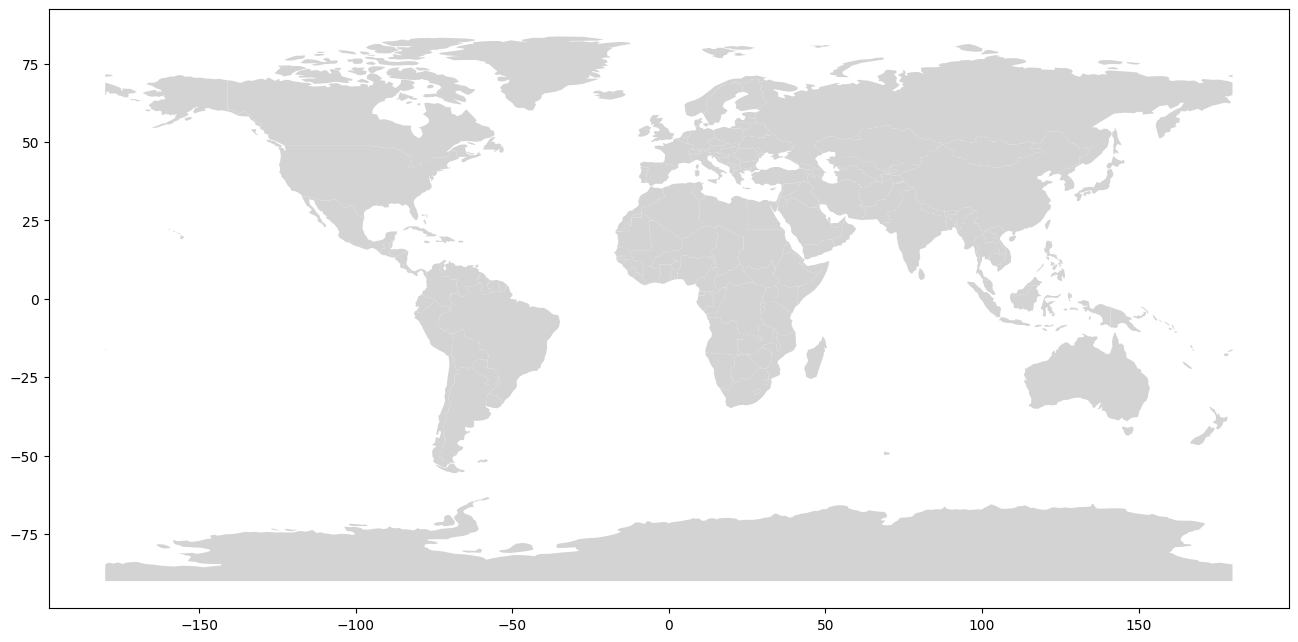

In [24]:
# Getting world map data from geo pandas
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(16, 10))
worldmap.plot(color="lightgrey", ax=ax)

# Plotting Longitudes and Latitudes of one boat
x = geo_df['lon']
y = geo_df['lat']
boats = geo_df['type']
plt.scatter(x, y, c=boats, cmap='autumn')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()